# Weight Regularization

```
- The goal is to find the weights that minimize the cost function.
```

In [1]:
# Built-in library
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Custom import
from src.utilities import create_iris_data, smooth


# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
# Configure the backend
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

## L2 Regularization

```text
- AKA Ridge/weight decay.
- It forces the weights to be small but does not make them zero.
- It's not robust to outliers.
- It can learn complex patterns in the data.
- It adds the regularized term which is lambda and the dot product of weights.
```

$$J = \frac{1}{n}\sum_{i=1}^n{L(\hat{y}_i, y_i) + \lambda ||W||^2_{2}}$$

In [3]:
# Load Iris data
X, y = create_iris_data()

TEST_SIZE, RAMDOM_STATE = 0.2, 123
BATCH_SIZE = 16

# Split the data
X_train, X_validation, y_train, y_validation = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RAMDOM_STATE,
)

X_train.shape, X_validation.shape

Shape of X: torch.Size([150, 4]), Shape of X: torch.Size([150])


(torch.Size([120, 4]), torch.Size([30, 4]))

In [4]:
# Create dataset objects
train_data = TensorDataset(X_train, y_train)
validation_data = TensorDataset(X_validation, y_validation)

# Create dataloader objects
train_DL = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
validation_DL = DataLoader(
    dataset=validation_data, batch_size=validation_data.tensors[0].shape[0]
)

In [5]:
class Net(nn.Module):
    """This is an ANN architecture. The output layer has 3 units."""

    def __init__(self, n_units: int) -> None:
        super().__init__()
        # Layers
        self.input = nn.Linear(4, n_units)
        self.hidden = nn.Linear(n_units, n_units)
        self.output = nn.Linear(n_units, 3)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used to perform forward propagation."""
        X = F.relu(self.input(X))
        X = F.relu(self.hidden(X))
        X = torch.softmax(self.output(X), dim=1)

        return X


def train_iris_model(
    *,
    train_data_loader: DataLoader,
    validation_data_loader: DataLoader,
    l2_lambda: float,
    n_units: int = 64,
) -> tuple[list[float], list[float], list[float]]:
    """This is used to train the classifier."""
    net = Net(n_units=n_units)

    learning_rate, epochs = 0.01, 500
    PCT = 100
    optimizer = torch.optim.SGD(
        params=net.parameters(),
        lr=learning_rate,
        weight_decay=l2_lambda,  # L2 regularization
    )
    criterion, losses = nn.CrossEntropyLoss(), []
    train_accuracy, validation_accuracy = [], []

    for epoch_idx in np.arange(epochs):
        batch_accuracy, batch_loss = [], []
        net.train()  # Activate regularization

        for X_, y_ in train_data_loader:
            # Reset gradients
            optimizer.zero_grad()

            # Compute forward prop and loss
            _y_proba = net(X_)
            loss = criterion(_y_proba, y_)
            batch_loss.append(loss.detach())

            # Compute backward prop
            loss.backward()
            optimizer.step()

            # Compute batch accuracy
            _y_pred = torch.argmax(_y_proba, axis=1)
            acc = torch.mean((_y_pred == y_).float()) * PCT
            batch_accuracy.append(acc.detach())

        # Compute training loss and accuracy
        train_accuracy.append(np.mean(batch_accuracy))
        losses.append(np.mean(batch_loss))

        # Compute validation accuracy
        net.eval()  # Deactivate regularization

        X_val, y_val = next(iter(validation_data_loader))
        _y_pred_val = torch.argmax(net(X_val), axis=1)
        _val_acc = torch.mean((_y_pred_val == y_val).float()) * PCT
        validation_accuracy.append(_val_acc.detach())

    return (train_accuracy, validation_accuracy, losses)

In [6]:
L2_lambda = 0.02
train_accuracy, validation_accuracy, losses = train_iris_model(
    train_data_loader=train_DL,
    validation_data_loader=validation_DL,
    l2_lambda=L2_lambda,
    n_units=16,
)

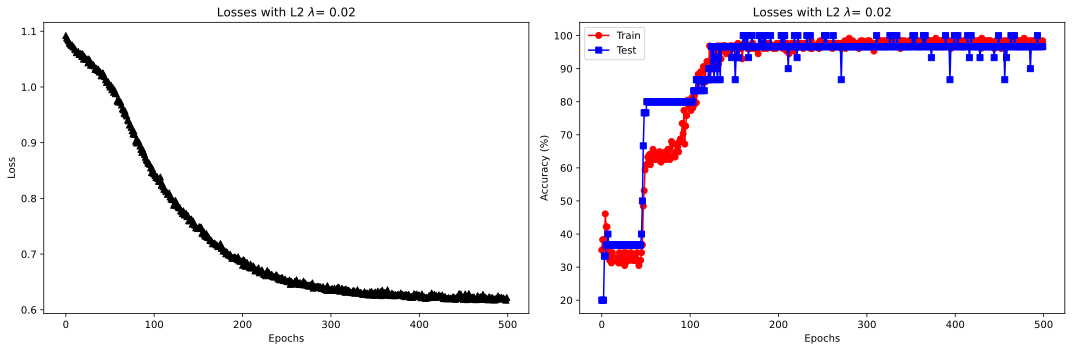

In [7]:
# Visualize
_, ax = plt.subplots(1, 2, figsize=(15, 5))


ax[0].plot(losses, "k^-")
ax[0].set(
    xlabel="Epochs",
    ylabel="Loss",
    title=f"Losses with L2 $\lambda$= {L2_lambda}",
)

ax[1].plot(train_accuracy, "ro-")
ax[1].plot(validation_accuracy, "bs-")
ax[1].set(
    xlabel="Epochs",
    ylabel="Accuracy (%)",
    title=f"Losses with L2 $\lambda$= {L2_lambda}",
)
ax[1].legend(["Train", "Test"])

plt.tight_layout()
plt.show()

#### Parametric Experiment

```text
- Try a few L2_lambda values.
```

In [8]:
epochs, L2_lambdas = 500, np.linspace(0, 0.1, 10)
accuracy_train, accuracy_val = (
    np.zeros(shape=(epochs, L2_lambdas.shape[0])),
    np.zeros(shape=(epochs, L2_lambdas.shape[0])),
)

for idx, l2_l in enumerate(L2_lambdas):
    train_acc, validation_acc, _ = train_iris_model(
        train_data_loader=train_DL,
        validation_data_loader=validation_DL,
        l2_lambda=l2_l,
        n_units=16,
    )
    accuracy_train[:, idx] = smooth(X=train_acc, k=10)
    accuracy_val[:, idx] = smooth(X=validation_acc, k=10)

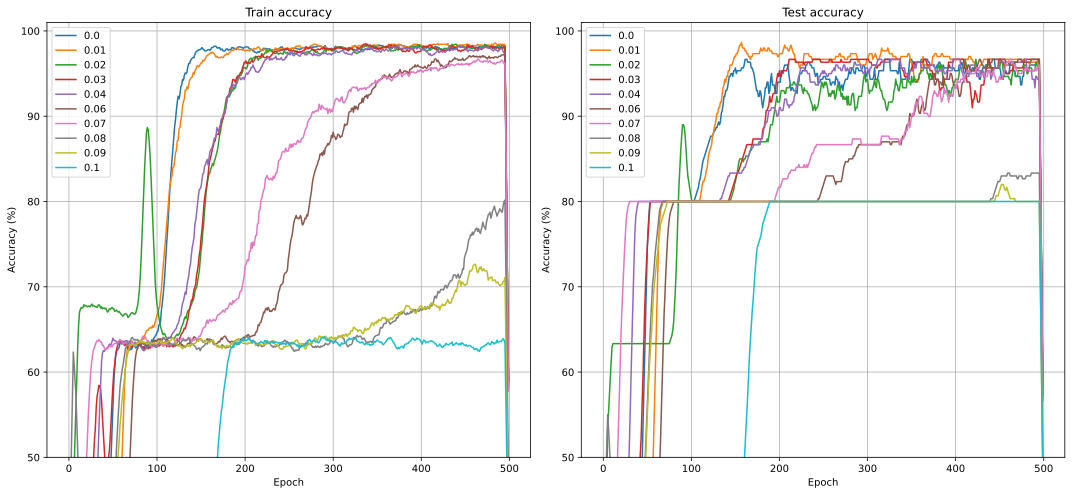

In [9]:
# Visualize the results
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].plot(accuracy_train)
ax[0].set_title("Train accuracy")

ax[1].plot(accuracy_val)
ax[1].set_title("Test accuracy")

# make the legend easier to read
leglabels = [np.round(i, 2) for i in L2_lambdas]

# common features
for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracy (%)")
    ax[i].set_ylim([50, 101])
    ax[i].grid()

plt.tight_layout()
plt.show()